In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils import grid_evaluate
from sklearn.neural_network import MLPClassifier


#Load the saved CSVs
X_train = pd.read_csv('X_train.csv')
X_validation = pd.read_csv('X_validation.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
y_validation = pd.read_csv('y_validation.csv')
y_test = pd.read_csv('y_test.csv')


#Squeeze to make them series
y_train = y_train.squeeze()
y_validation = y_validation.squeeze()
y_test = y_test.squeeze()

#Define the base model
base_clf = MLPClassifier(
    max_iter=3000,
    random_state=42
)

param_grid = {
    'hidden_layer_sizes': [(15,), (20,), (15,15)],
    'activation':         ['relu', 'tanh'], #logistic = sigmoid
    'alpha':              [1e-4, 1e-3, 1e-2, 1e-1, 1, 10], #L2 penalty (weight decay)
    'learning_rate_init': [1e-3, 1e-2],
}

results_nn, best_model = grid_evaluate(
    estimator  = base_clf,
    param_grid = param_grid,
    X_train    = X_train,
    X_validation     = X_validation,
    y_train    = y_train,
    y_validation    = y_validation
)

#drop unnecessary columns (not modified in neural network model)
results_nn = results_nn.drop(
    columns=['feature_method','degree','n_components','gamma'],
    errors='ignore'
)

#Inspect best model by F1
best_nn = results_nn.sort_values('f1_validation', ascending=False)
print(best_nn.head)


Evaluated 5 parameter combinations...
Evaluated 10 parameter combinations...
Evaluated 15 parameter combinations...
Evaluated 20 parameter combinations...
Evaluated 25 parameter combinations...
Evaluated 30 parameter combinations...
Evaluated 35 parameter combinations...
Evaluated 40 parameter combinations...
Evaluated 45 parameter combinations...
Evaluated 50 parameter combinations...
Evaluated 55 parameter combinations...
Evaluated 60 parameter combinations...
Evaluated 65 parameter combinations...
Evaluated 70 parameter combinations...
<bound method NDFrame.head of     accuracy_validation  accuracy_train  precision_validation  \
11                0.728        0.973226              0.448276   
24                0.780        0.840696              0.600000   
25                0.760        0.859438              0.525000   
17                0.712        0.969210              0.416667   
27                0.768        0.847390              0.555556   
..                  ...            

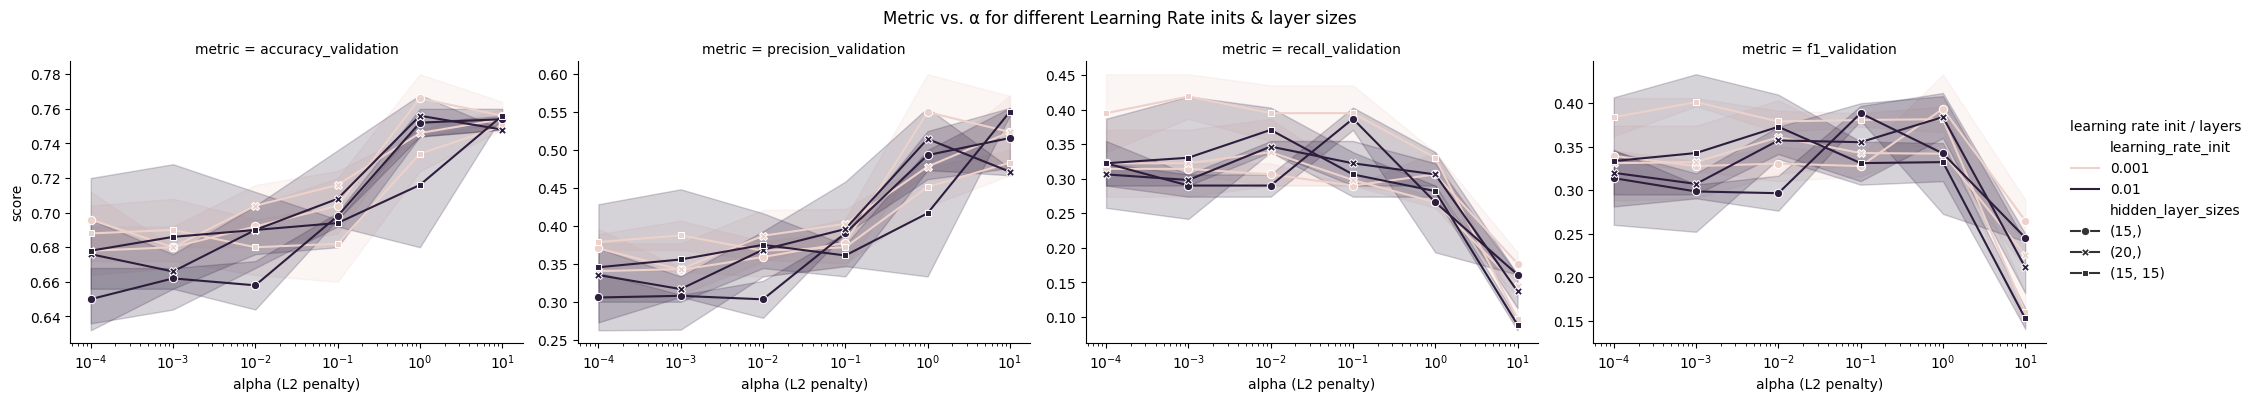

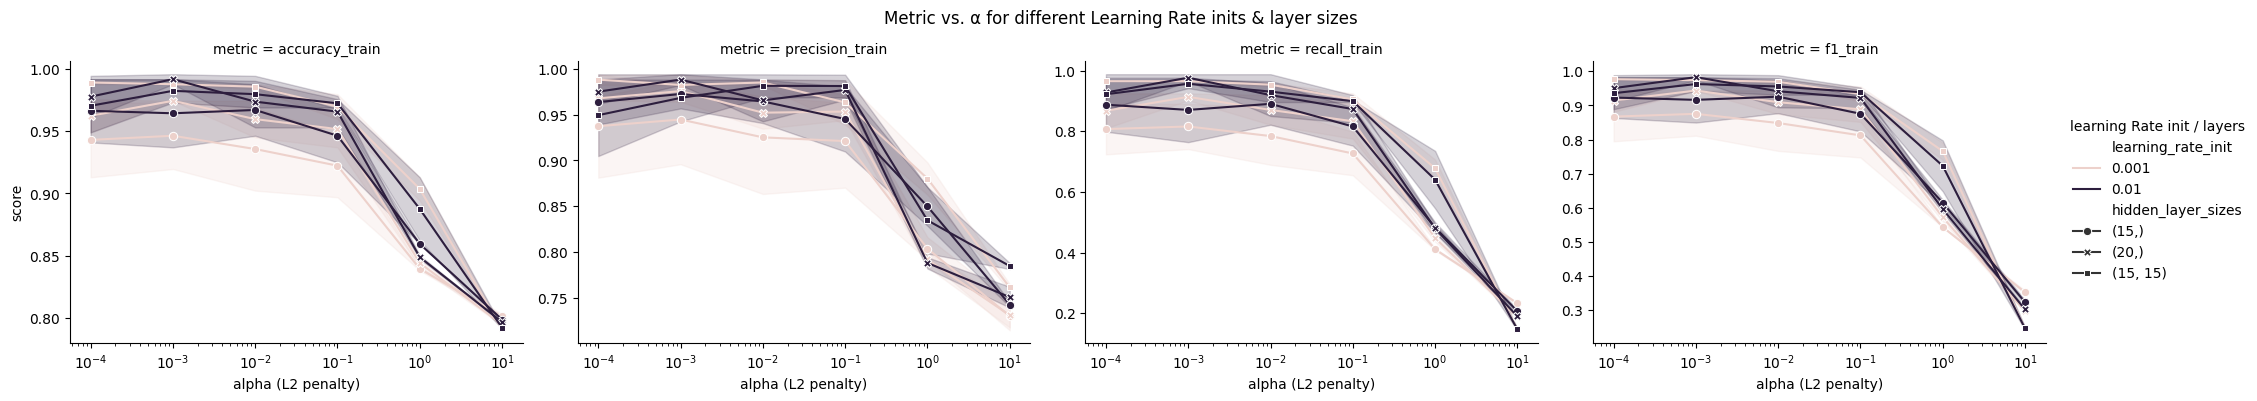

In [10]:
df = results_nn


metrics = [
    'accuracy_validation',
    'precision_validation',
    'recall_validation',
    'f1_validation',
]

#reshapping df for easier plotting
df_long_val = df.melt(
    id_vars=['hidden_layer_sizes','activation','alpha','learning_rate_init'],
    value_vars=metrics,
    var_name='metric',
    value_name='score'
)


#using sns to visualize the results (validation)
g = sns.FacetGrid(
    df_long_val, 
    col='metric', 
    sharey=False, 
    height=4, 
    aspect=1.3
)

g.map_dataframe(
    sns.lineplot,
    x='alpha', 
    y='score',
    hue='learning_rate_init',
    style='hidden_layer_sizes',
    markers=True,
    dashes=False
)

g.set(xscale='log') #log scale to visualize alpha better
g.add_legend(title='learning rate init / layers')
g.set_axis_labels('alpha (L2 penalty)','score')
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Metric vs. α for different Learning Rate inits & layer sizes')
plt.show()

metrics = ['accuracy_train','precision_train','recall_train','f1_train']
df_long_train = df.melt(
    id_vars=['hidden_layer_sizes','activation','alpha','learning_rate_init'],
    value_vars=metrics,
    var_name='metric',
    value_name='score'
)

#using sns to visualize the results (train)
g = sns.FacetGrid(
    df_long_train, 
    col='metric', 
    sharey=False, 
    height=4, 
    aspect=1.3
)

g.map_dataframe(
    sns.lineplot,
    x='alpha', 
    y='score',
    hue='learning_rate_init',
    style='hidden_layer_sizes',
    markers=True,
    dashes=False
)

g.set(xscale='log') #log scale to visualize alpha better
g.add_legend(title='learning Rate init / layers')
g.set_axis_labels('alpha (L2 penalty)','score')
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Metric vs. α for different Learning Rate inits & layer sizes')
plt.show()



In [11]:
best_nn.to_csv('nn_results.csv', index=False)
print("Saved results to nn_results.csv")

Saved results to nn_results.csv


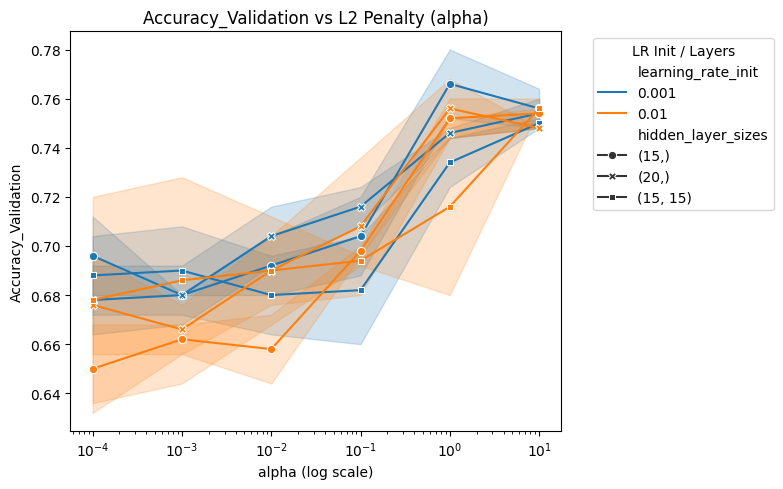

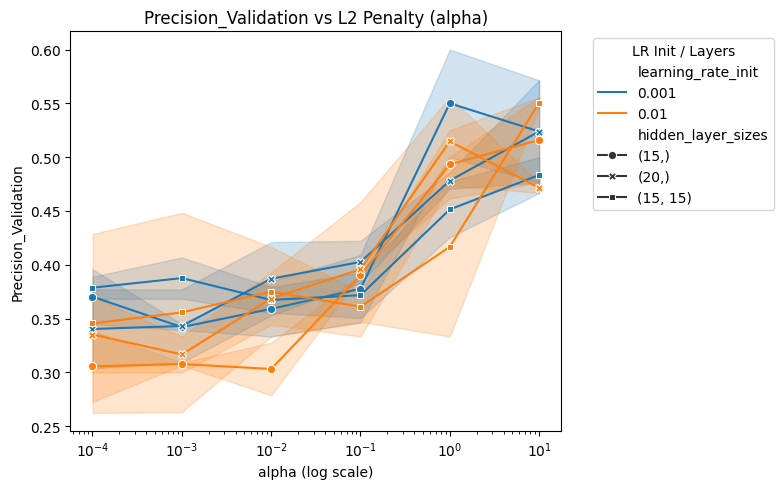

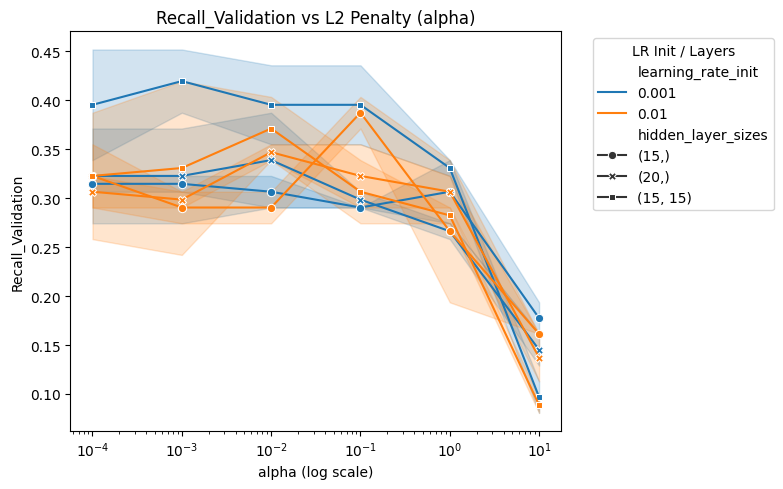

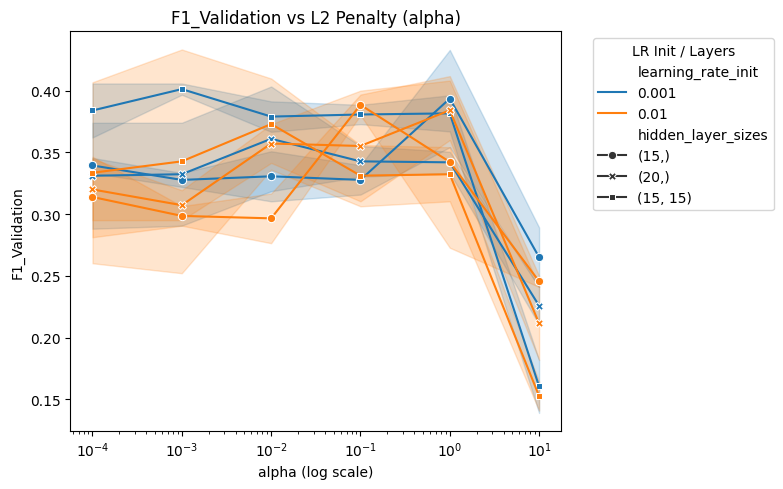

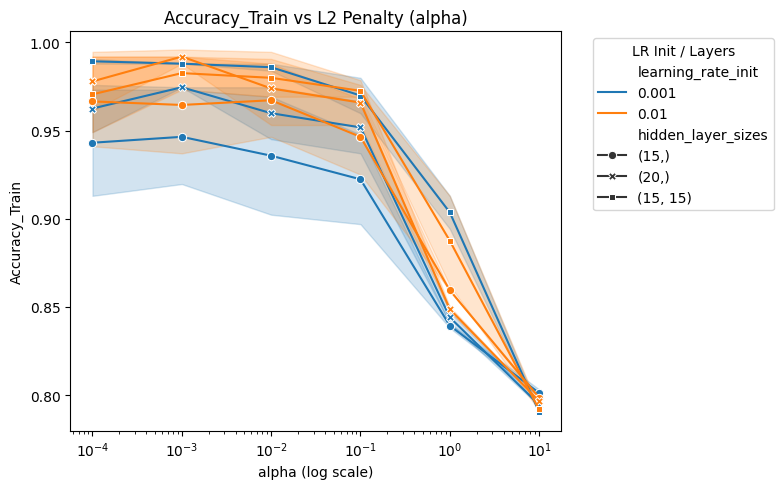

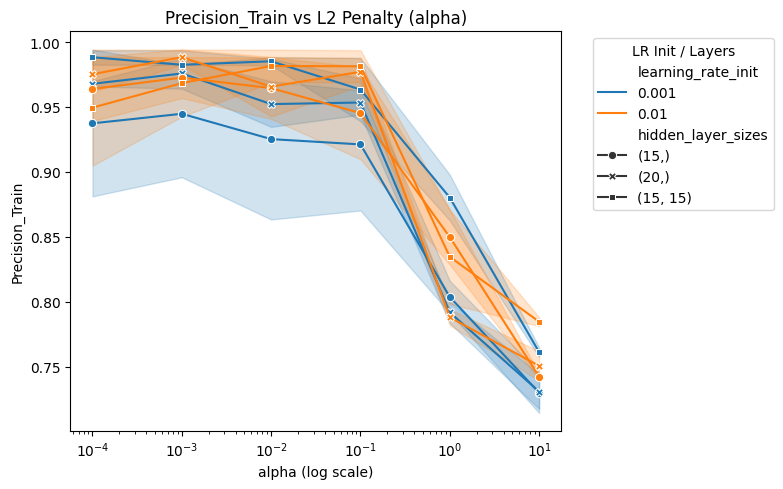

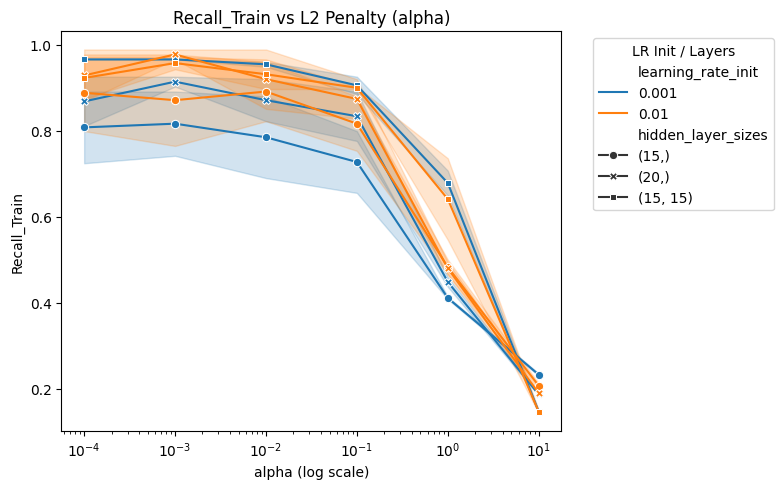

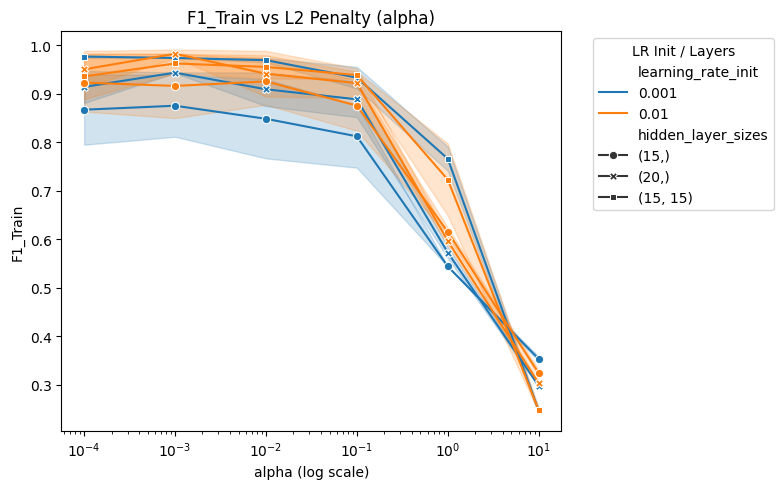

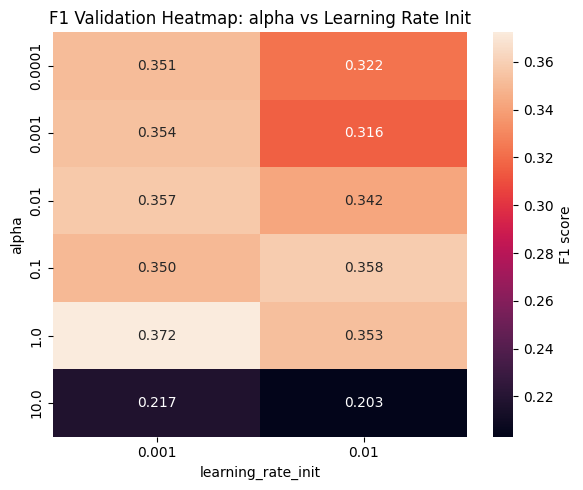

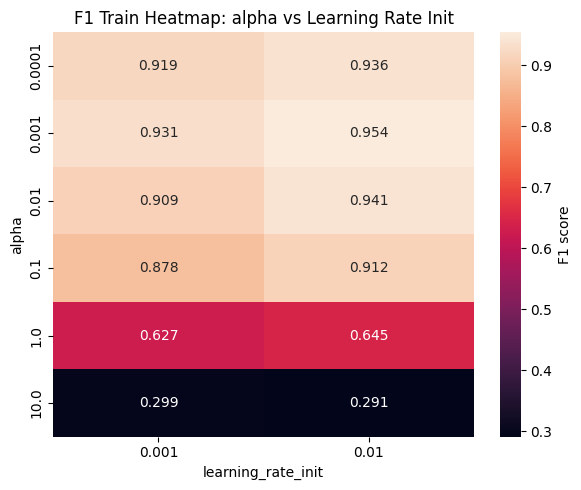

/var/folders/ss/4d6r1qn954dch_yq8dq36s8c0000gn/T/ipykernel_46134/1745484106.py:59: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


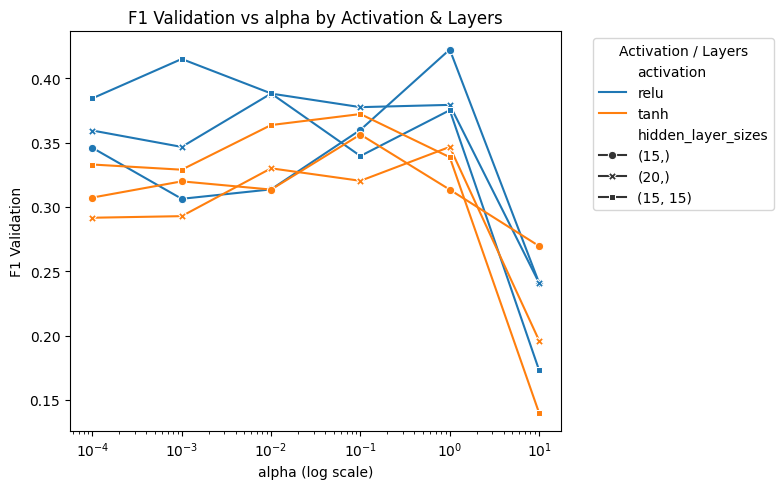

/var/folders/ss/4d6r1qn954dch_yq8dq36s8c0000gn/T/ipykernel_46134/1745484106.py:59: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


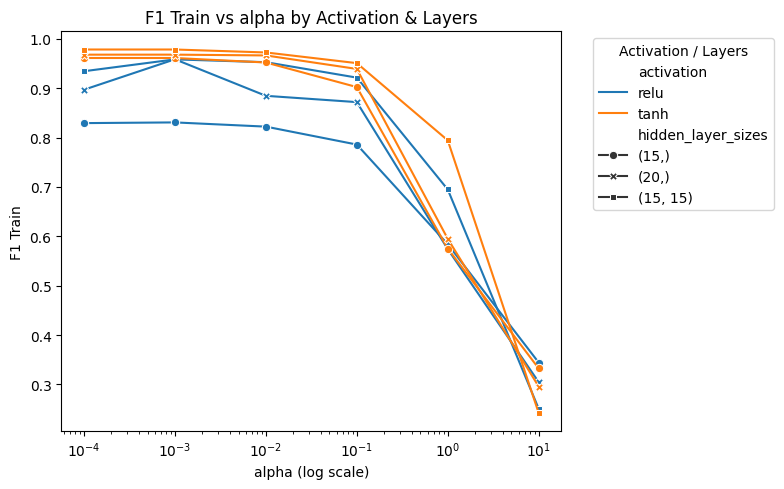

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

metrics = [
    'accuracy_validation',
    'precision_validation',
    'recall_validation',
    'f1_validation',
    'accuracy_train',
    'precision_train',
    'recall_train',
    'f1_train',
]

#Line‐plots of each metric vs alpha
for metric in metrics:
    plt.figure(figsize=(8,5))
    sns.lineplot(
        data   = df,
        x      = 'alpha',
        y      = metric,
        hue    = 'learning_rate_init',
        style  = 'hidden_layer_sizes',
        palette= 'tab10',
        markers=True,
        dashes=False
    )
    plt.xscale('log')
    plt.title(f'{metric.title()} vs L2 Penalty (alpha)')
    plt.ylabel(metric.title())
    plt.xlabel('alpha (log scale)')
    plt.legend(title='LR Init / Layers', bbox_to_anchor=(1.05,1), loc='upper left')
    plt.tight_layout()
    plt.show()

#Heatmaps of F1 over (alpha, learning_rate_init)
for split in ['validation', 'train']:
    pivot = df.pivot_table(
        index='alpha',
        columns='learning_rate_init',
        values=f'f1_{split}'
    )
    plt.figure(figsize=(6,5))
    sns.heatmap(
        pivot,
        annot=True,
        fmt='.3f',
        cbar_kws={'label':'F1 score'}
    )
    plt.title(f'F1 {split.title()} Heatmap: alpha vs Learning Rate Init')
    plt.xlabel('learning_rate_init')
    plt.ylabel('alpha')
    plt.tight_layout()
    plt.show()

#Activation comparison (F1 vs alpha)
for split in ['validation', 'train']:
    plt.figure(figsize=(8,5))
    sns.lineplot(
        data   = df,
        x      = 'alpha',
        y      = f'f1_{split}',
        hue    = 'activation',
        style  = 'hidden_layer_sizes',
        ci     = None,
        markers=True,
        dashes=False,
        palette='tab10'
    )
    plt.xscale('log')
    plt.title(f'F1 {split.title()} vs alpha by Activation & Layers')
    plt.xlabel('alpha (log scale)')
    plt.ylabel(f'F1 {split.title()}')
    plt.legend(title='Activation / Layers', bbox_to_anchor=(1.05,1), loc='upper left')
    plt.tight_layout()
    plt.show()


In [13]:
best_nn = results_nn.sort_values('f1_validation', ascending=False)
print(best_nn.head())

    accuracy_validation  accuracy_train  precision_validation  \
11                0.728        0.973226              0.448276   
24                0.780        0.840696              0.600000   
25                0.760        0.859438              0.525000   
17                0.712        0.969210              0.416667   
27                0.768        0.847390              0.555556   

    recall_validation  f1_validation  precision_train  recall_train  f1_train  \
11           0.419355       0.433333         0.942529      0.942529  0.942529   
24           0.338710       0.432990         0.816092      0.408046  0.544061   
25           0.338710       0.411765         0.828571      0.500000  0.623656   
17           0.403226       0.409836         0.968944      0.896552  0.931343   
27           0.322581       0.408163         0.794118      0.465517  0.586957   

   activation  alpha hidden_layer_sizes  learning_rate_init  
11       relu  0.001           (15, 15)               0.010 

In [14]:
best_nn_model = results_nn.nlargest(1, 'f1_validation')
print(best_nn_model)
print(best_model)

    accuracy_validation  accuracy_train  precision_validation  \
11                0.728        0.973226              0.448276   

    recall_validation  f1_validation  precision_train  recall_train  f1_train  \
11           0.419355       0.433333         0.942529      0.942529  0.942529   

   activation  alpha hidden_layer_sizes  learning_rate_init  
11       relu  0.001           (15, 15)                0.01  
MLPClassifier(alpha=0.001, hidden_layer_sizes=(15, 15), learning_rate_init=0.01,
              max_iter=3000, random_state=42)


In [15]:
from sklearn.metrics import precision_recall_fscore_support,accuracy_score
y_pred_test = best_model.predict(X_test)

#test metrics
acc_val  = accuracy_score(y_test, y_pred_test)
prec_test, rec_test, f1_test, _ = precision_recall_fscore_support(
    y_test, y_pred_test, average='binary', zero_division=0
)

metrics = {
    'model': 'Neural Network',
    'accuracy': acc_val,
    'precision': prec_test,
    'recall': rec_test,
    'f1_score': f1_test
}

df = pd.DataFrame([metrics])
df.to_csv('testresults.csv', mode='a', header=False, index=False)

print(f"Test Accuracy: {acc_val:.4f}")
print(f"Test Precision: {prec_test:.4f}")
print(f"Test Recall: {rec_test:.4f}")
print(f"Test F1 Score: {f1_test:.4f}")

Test Accuracy: 0.7920
Test Precision: 0.5263
Test Recall: 0.5455
Test F1 Score: 0.5357
